# Steam Review Classification
Avery Wynn (Avery.j.wynn@gmail.com)

Fine-tuning a BERT model for classifying and predicting Steam reviews as 'Recommended' or 'Not Recommended'

Dataset used: https://www.kaggle.com/datasets/andrewmvd/steam-reviews

In [ ]:
!pip install kaggle
!kaggle datasets download -d andrewmvd/steam-reviews

# Windows (local)
!tar -xf steam-reviews.zip

# Linux (Colab)
# !unzip steam-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/steam-reviews
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
steam-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !pip install --upgrade pip

# Linux (Colab)
# !pip install --disable-pip-version-check \
#     torch==2.3.0 \
#     torchdata==0.7.1 --quiet
# !pip install \
#     transformers==4.27.2 \
#     datasets==2.11.0  --quiet


# Windows
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install \
    transformers \
    datasets  --quiet
!pip install scikit-learn
!pip install matplotlib
!pip install numpy

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch
import numpy as np
from sklearn.model_selection import train_test_split

c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Verify we're using a GPU if possible.
import torch

print('GPU Enabled? ' + str(torch.cuda.is_available()))

GPU Enabled? True


In [ ]:
import random
# Seed to enable reproducability.
seed = 3234


# Randomly sample the csv, takes way longer to count, but is more likely to give both positive and negative labels.
csv_path = "dataset.csv"
# Read in dataset.
total_rows = 0
for row in open(csv_path):
  total_rows+= 1

num_rows = 10000
random.seed(seed)
skip = sorted(random.sample(range(total_rows),total_rows-num_rows))


reviews_df_raw = pd.read_csv(csv_path, nrows=num_rows)

In [ ]:
# Map "review_score" to "recommended". It's binary. Also filter out any empty reviews.
reviews_df_raw = reviews_df_raw.rename(columns={'review_score': 'recommended'})[reviews_df_raw.review_text != '']
reviews_df = reviews_df_raw[['recommended', 'review_text']]

# Translates -1 to 0
reviews_df['recommended'] = reviews_df['recommended'].transform(lambda rec: 0 if rec == -1 else 1).astype(int)

reviews_df['review_text'] = reviews_df['review_text'].astype(str)

C:\Users\Owner\AppData\Local\Temp\ipykernel_9512\33696507.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['recommended'] = reviews_df['recommended'].transform(lambda rec: 0 if rec == -1 else 1).astype(int)
C:\Users\Owner\AppData\Local\Temp\ipykernel_9512\33696507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].astype(str)


In [ ]:
# Test set sampling percentage.
test_sample_pct = 0.1

# Split data
review_texts = reviews_df.review_text
labels = reviews_df.recommended
text_train, text_test, label_train, label_test = train_test_split(review_texts, labels,random_state = seed, test_size=test_sample_pct)

# Format into train and test dataframes.
df_train = pd.DataFrame({'review_text': text_train.to_numpy(), 'recommended': label_train.to_numpy()})
df_test = pd.DataFrame({'review_text': text_test.to_numpy(), 'recommended': label_test.to_numpy()})

In [ ]:
# Verify there is sufficient positive and negative data.
print("Num pos train: " + str(len(df_train[df_train.recommended == 1])))
print("Num neg train: " + str(len(df_train[df_train.recommended == 0])))

print("Num pos test: " + str(len(df_test[df_test.recommended == 1])))
print("Num neg test: " + str(len(df_test[df_test.recommended == 0])))

Num pos train: 8692
Num neg train: 308
Num pos test: 945
Num neg test: 55


In [ ]:
# Use 'bert-base-uncased' tokenizer.
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
sequence_length = 128

# Texts are going to vary in length and require truncation.
def tokenize(batch):
    # Length impacts max batch size. MAX of 512.
    tokenized_inputs = tokenizer(batch['review_text'], padding=True, truncation=True, max_length=sequence_length, return_tensors='pt')

    # Recommended is the label.
    tokenized_inputs["labels"] = torch.tensor(batch['recommended'])
    return tokenized_inputs

train_dataset = Dataset.from_pandas(df_train).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(df_test).map(tokenize, batched=True)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 5380.95 examples/s]


In [ ]:
# The model expects inputs in this format.
train_dataset.set_format('torch', columns=['input_ids', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'labels'])


In [ ]:
# Initializing the model
version_number = 1 # Change to stored version
dir_name = "./models/m_{sequence_length}_{num_rows}".format(sequence_length=sequence_length, num_rows=num_rows)
dir_name_w_version = "{dir_name}_v{version_number}".format(dir_name=dir_name, version_number=version_number)

# Pre-trained https://huggingface.co/google-bert/bert-base-uncased
pre_trained_name = 'bert-base-uncased'

# To use the saved fine-tuned model
# pre_trained_name = dir_name_w_version

model = AutoModelForSequenceClassification.from_pretrained(
    pre_trained_name,
    num_labels=2, # These must match the pre-trained model!
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# fp16's speedup requires a GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training Args
num_epochs = 3
batch_size = 8
learning_rate = 1e-5 # This seems common.
weight_decay = 0.01 # Helps prevent overfitting with large weight swings.

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
    fp16=(device == 'cuda')
)

c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#Compute evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(all_preds):
    labels = all_preds.label_ids
    preds = all_preds.predictions

    # Convert predictions into just the labels.
    predicted_labels = np.argmax(preds, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted')
    acc_score = accuracy_score(labels, predicted_labels)

    return {
        'accuracy': acc_score,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [ ]:
# The Trainer API abstracts the training and eval loop with some optimizations
#  for torch based Transformers.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
from sklearn.metrics import confusion_matrix

# Print a confusion matrix for a given trainer.
def print_confusion_matrix(trainer, test_dataset):
    # Get the predictions from the trainer
    predictions = trainer.predict(test_dataset)

    # Convert the predictions to labels
    found_labels = np.argmax(predictions.predictions, axis=1)

    # Get the true labels
    true_labels = test_dataset['labels']

    # Create the confusion matrix
    c_m = confusion_matrix(true_labels, found_labels)

    # Print the confusion matrix
    print('Confusion Matrix')
    print(np.asarray([['TN','FP'],['FN','TP']]))
    print('')
    print(c_m)

In [ ]:
# Without tuning, the model should perform really poorly.
trainer.evaluate()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 125/125 [00:04<00:00, 30.99it/s]


{'eval_loss': 0.7630214691162109,
 'eval_accuracy': 0.079,
 'eval_f1': 0.05267923474458955,
 'eval_precision': 0.9480993852459016,
 'eval_recall': 0.079,
 'eval_runtime': 4.5189,
 'eval_samples_per_second': 221.291,
 'eval_steps_per_second': 27.661}

In [ ]:
# Without tuning, this is all guessing.
print_confusion_matrix(trainer, test_dataset)

100%|██████████| 125/125 [00:04<00:00, 29.90it/s]

Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]

[[ 55   0]
 [921  24]]


In [ ]:
# Execute epoch training on the prescribed model. DON'T RUN IF THE MODEL IS PRE-FINETUNED
trainer.train()

  0%|          | 11/3375 [00:02<07:55,  7.07it/s]

{'loss': 0.3653, 'grad_norm': 4.0121588706970215, 'learning_rate': 9.970370370370372e-06, 'epoch': 0.01}


  1%|          | 21/3375 [00:03<07:50,  7.13it/s]

{'loss': 0.1784, 'grad_norm': 2.661689281463623, 'learning_rate': 9.940740740740742e-06, 'epoch': 0.02}


  1%|          | 31/3375 [00:05<08:42,  6.40it/s]

{'loss': 0.051, 'grad_norm': 0.614512026309967, 'learning_rate': 9.911111111111113e-06, 'epoch': 0.03}


  1%|          | 41/3375 [00:06<08:01,  6.92it/s]

{'loss': 0.172, 'grad_norm': 0.5303570628166199, 'learning_rate': 9.881481481481483e-06, 'epoch': 0.04}


  2%|▏         | 51/3375 [00:07<07:24,  7.49it/s]

{'loss': 0.2675, 'grad_norm': 1.6418449878692627, 'learning_rate': 9.851851851851852e-06, 'epoch': 0.04}


  2%|▏         | 61/3375 [00:09<07:16,  7.60it/s]

{'loss': 0.1478, 'grad_norm': 0.40246203541755676, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.05}


  2%|▏         | 71/3375 [00:10<07:07,  7.74it/s]

{'loss': 0.2822, 'grad_norm': 0.6364879608154297, 'learning_rate': 9.792592592592593e-06, 'epoch': 0.06}


  2%|▏         | 81/3375 [00:11<07:04,  7.77it/s]

{'loss': 0.2816, 'grad_norm': 0.6245042085647583, 'learning_rate': 9.762962962962964e-06, 'epoch': 0.07}


  3%|▎         | 91/3375 [00:12<06:58,  7.84it/s]

{'loss': 0.0141, 'grad_norm': 0.2751873731613159, 'learning_rate': 9.733333333333334e-06, 'epoch': 0.08}


  3%|▎         | 101/3375 [00:14<06:54,  7.90it/s]

{'loss': 0.0097, 'grad_norm': 0.16033175587654114, 'learning_rate': 9.703703703703703e-06, 'epoch': 0.09}


  3%|▎         | 111/3375 [00:15<07:21,  7.40it/s]

{'loss': 0.1359, 'grad_norm': 0.24679329991340637, 'learning_rate': 9.674074074074075e-06, 'epoch': 0.1}


  4%|▎         | 121/3375 [00:16<07:12,  7.52it/s]

{'loss': 0.2512, 'grad_norm': 6.83230447769165, 'learning_rate': 9.644444444444444e-06, 'epoch': 0.11}


  4%|▍         | 131/3375 [00:18<07:00,  7.71it/s]

{'loss': 0.1731, 'grad_norm': 3.6928083896636963, 'learning_rate': 9.614814814814816e-06, 'epoch': 0.12}


  4%|▍         | 141/3375 [00:19<07:05,  7.60it/s]

{'loss': 0.1307, 'grad_norm': 0.23167306184768677, 'learning_rate': 9.585185185185187e-06, 'epoch': 0.12}


  4%|▍         | 151/3375 [00:20<06:47,  7.91it/s]

{'loss': 0.1925, 'grad_norm': 0.29327312111854553, 'learning_rate': 9.555555555555556e-06, 'epoch': 0.13}


  5%|▍         | 161/3375 [00:22<06:46,  7.91it/s]

{'loss': 0.272, 'grad_norm': 0.6012609601020813, 'learning_rate': 9.525925925925926e-06, 'epoch': 0.14}


  5%|▌         | 171/3375 [00:23<07:14,  7.38it/s]

{'loss': 0.2129, 'grad_norm': 0.47297826409339905, 'learning_rate': 9.49925925925926e-06, 'epoch': 0.15}


  5%|▌         | 181/3375 [00:24<06:59,  7.62it/s]

{'loss': 0.063, 'grad_norm': 4.404714107513428, 'learning_rate': 9.469629629629632e-06, 'epoch': 0.16}


  6%|▌         | 191/3375 [00:25<06:50,  7.76it/s]

{'loss': 0.2427, 'grad_norm': 0.2975022792816162, 'learning_rate': 9.440000000000001e-06, 'epoch': 0.17}


  6%|▌         | 201/3375 [00:27<06:45,  7.82it/s]

{'loss': 0.1253, 'grad_norm': 0.19742009043693542, 'learning_rate': 9.41037037037037e-06, 'epoch': 0.18}


  6%|▋         | 211/3375 [00:28<07:50,  6.72it/s]

{'loss': 0.2635, 'grad_norm': 0.1662430465221405, 'learning_rate': 9.380740740740742e-06, 'epoch': 0.19}


  7%|▋         | 221/3375 [00:30<08:51,  5.93it/s]

{'loss': 0.2992, 'grad_norm': 0.6203111410140991, 'learning_rate': 9.351111111111112e-06, 'epoch': 0.2}


  7%|▋         | 231/3375 [00:32<08:54,  5.88it/s]

{'loss': 0.2828, 'grad_norm': 2.6012213230133057, 'learning_rate': 9.321481481481483e-06, 'epoch': 0.2}


  7%|▋         | 241/3375 [00:33<07:07,  7.34it/s]

{'loss': 0.1686, 'grad_norm': 2.906287670135498, 'learning_rate': 9.291851851851852e-06, 'epoch': 0.21}


  7%|▋         | 251/3375 [00:34<06:41,  7.79it/s]

{'loss': 0.1503, 'grad_norm': 0.5329411029815674, 'learning_rate': 9.262222222222222e-06, 'epoch': 0.22}


  8%|▊         | 261/3375 [00:36<06:54,  7.51it/s]

{'loss': 0.1188, 'grad_norm': 0.27371373772621155, 'learning_rate': 9.232592592592593e-06, 'epoch': 0.23}


  8%|▊         | 271/3375 [00:37<06:49,  7.58it/s]

{'loss': 0.0084, 'grad_norm': 0.1484575718641281, 'learning_rate': 9.202962962962963e-06, 'epoch': 0.24}


  8%|▊         | 281/3375 [00:38<06:33,  7.86it/s]

{'loss': 0.1404, 'grad_norm': 0.14034484326839447, 'learning_rate': 9.173333333333334e-06, 'epoch': 0.25}


  9%|▊         | 291/3375 [00:40<06:47,  7.56it/s]

{'loss': 0.1387, 'grad_norm': 0.3061051070690155, 'learning_rate': 9.143703703703705e-06, 'epoch': 0.26}


  9%|▉         | 301/3375 [00:41<06:42,  7.64it/s]

{'loss': 0.0731, 'grad_norm': 0.15765617787837982, 'learning_rate': 9.114074074074075e-06, 'epoch': 0.27}


  9%|▉         | 311/3375 [00:42<06:40,  7.65it/s]

{'loss': 0.135, 'grad_norm': 0.30595603585243225, 'learning_rate': 9.084444444444446e-06, 'epoch': 0.28}


 10%|▉         | 321/3375 [00:44<06:29,  7.84it/s]

{'loss': 0.1901, 'grad_norm': 0.20386235415935516, 'learning_rate': 9.054814814814816e-06, 'epoch': 0.28}


 10%|▉         | 331/3375 [00:45<06:27,  7.86it/s]

{'loss': 0.1944, 'grad_norm': 3.239652156829834, 'learning_rate': 9.025185185185185e-06, 'epoch': 0.29}


 10%|█         | 341/3375 [00:46<06:31,  7.74it/s]

{'loss': 0.2925, 'grad_norm': 4.210724830627441, 'learning_rate': 8.995555555555557e-06, 'epoch': 0.3}


 10%|█         | 351/3375 [00:48<06:28,  7.78it/s]

{'loss': 0.2266, 'grad_norm': 0.4637531340122223, 'learning_rate': 8.965925925925926e-06, 'epoch': 0.31}


 11%|█         | 361/3375 [00:49<06:23,  7.86it/s]

{'loss': 0.0642, 'grad_norm': 0.24400858581066132, 'learning_rate': 8.936296296296298e-06, 'epoch': 0.32}


 11%|█         | 371/3375 [00:50<06:52,  7.28it/s]

{'loss': 0.249, 'grad_norm': 0.19931058585643768, 'learning_rate': 8.906666666666667e-06, 'epoch': 0.33}


 11%|█▏        | 381/3375 [00:52<06:47,  7.35it/s]

{'loss': 0.1882, 'grad_norm': 0.2291562706232071, 'learning_rate': 8.877037037037037e-06, 'epoch': 0.34}


 12%|█▏        | 391/3375 [00:53<07:00,  7.09it/s]

{'loss': 0.1284, 'grad_norm': 0.30206361413002014, 'learning_rate': 8.847407407407408e-06, 'epoch': 0.35}


 12%|█▏        | 401/3375 [00:54<06:35,  7.52it/s]

{'loss': 0.2381, 'grad_norm': 0.2819352149963379, 'learning_rate': 8.817777777777778e-06, 'epoch': 0.36}


 12%|█▏        | 411/3375 [00:56<06:40,  7.40it/s]

{'loss': 0.2261, 'grad_norm': 0.7564303278923035, 'learning_rate': 8.788148148148149e-06, 'epoch': 0.36}


 12%|█▏        | 421/3375 [00:57<06:45,  7.28it/s]

{'loss': 0.2146, 'grad_norm': 0.4791322946548462, 'learning_rate': 8.75851851851852e-06, 'epoch': 0.37}


 13%|█▎        | 431/3375 [00:58<06:38,  7.39it/s]

{'loss': 0.0121, 'grad_norm': 0.16514040529727936, 'learning_rate': 8.72888888888889e-06, 'epoch': 0.38}


 13%|█▎        | 441/3375 [01:00<07:22,  6.63it/s]

{'loss': 0.0728, 'grad_norm': 0.1684313714504242, 'learning_rate': 8.69925925925926e-06, 'epoch': 0.39}


 13%|█▎        | 451/3375 [01:01<06:33,  7.42it/s]

{'loss': 0.2034, 'grad_norm': 3.05364990234375, 'learning_rate': 8.672592592592594e-06, 'epoch': 0.4}


 14%|█▎        | 461/3375 [01:03<06:28,  7.51it/s]

{'loss': 0.1339, 'grad_norm': 0.2147807776927948, 'learning_rate': 8.642962962962965e-06, 'epoch': 0.41}


 14%|█▍        | 471/3375 [01:04<06:32,  7.40it/s]

{'loss': 0.1222, 'grad_norm': 0.2676711678504944, 'learning_rate': 8.613333333333333e-06, 'epoch': 0.42}


 14%|█▍        | 481/3375 [01:05<06:23,  7.55it/s]

{'loss': 0.0729, 'grad_norm': 0.182602658867836, 'learning_rate': 8.583703703703704e-06, 'epoch': 0.43}


 15%|█▍        | 491/3375 [01:07<06:15,  7.68it/s]

{'loss': 0.1292, 'grad_norm': 0.1793936789035797, 'learning_rate': 8.554074074074075e-06, 'epoch': 0.44}


 15%|█▍        | 501/3375 [01:08<06:36,  7.25it/s]

{'loss': 0.1328, 'grad_norm': 0.21203777194023132, 'learning_rate': 8.524444444444445e-06, 'epoch': 0.44}


 15%|█▌        | 511/3375 [01:09<06:18,  7.57it/s]

{'loss': 0.2435, 'grad_norm': 0.23083972930908203, 'learning_rate': 8.494814814814816e-06, 'epoch': 0.45}


 15%|█▌        | 521/3375 [01:11<06:24,  7.41it/s]

{'loss': 0.3706, 'grad_norm': 3.269606590270996, 'learning_rate': 8.465185185185186e-06, 'epoch': 0.46}


 16%|█▌        | 531/3375 [01:12<06:32,  7.24it/s]

{'loss': 0.2183, 'grad_norm': 0.5308398008346558, 'learning_rate': 8.435555555555555e-06, 'epoch': 0.47}


 16%|█▌        | 541/3375 [01:13<06:11,  7.63it/s]

{'loss': 0.1222, 'grad_norm': 0.4045051038265228, 'learning_rate': 8.405925925925927e-06, 'epoch': 0.48}


 16%|█▋        | 551/3375 [01:15<06:06,  7.71it/s]

{'loss': 0.2907, 'grad_norm': 0.28400900959968567, 'learning_rate': 8.376296296296296e-06, 'epoch': 0.49}


 17%|█▋        | 561/3375 [01:16<06:38,  7.05it/s]

{'loss': 0.2327, 'grad_norm': 0.5790138244628906, 'learning_rate': 8.346666666666668e-06, 'epoch': 0.5}


 17%|█▋        | 571/3375 [01:18<06:39,  7.01it/s]

{'loss': 0.2615, 'grad_norm': 0.8853851556777954, 'learning_rate': 8.317037037037037e-06, 'epoch': 0.51}


 17%|█▋        | 581/3375 [01:19<07:49,  5.96it/s]

{'loss': 0.2157, 'grad_norm': 0.5564300417900085, 'learning_rate': 8.287407407407408e-06, 'epoch': 0.52}


 18%|█▊        | 591/3375 [01:21<06:38,  6.99it/s]

{'loss': 0.1778, 'grad_norm': 0.35616180300712585, 'learning_rate': 8.25777777777778e-06, 'epoch': 0.52}


 18%|█▊        | 601/3375 [01:22<06:21,  7.26it/s]

{'loss': 0.1213, 'grad_norm': 0.34394004940986633, 'learning_rate': 8.22814814814815e-06, 'epoch': 0.53}


 18%|█▊        | 611/3375 [01:23<06:53,  6.68it/s]

{'loss': 0.1229, 'grad_norm': 0.29714396595954895, 'learning_rate': 8.198518518518519e-06, 'epoch': 0.54}


 18%|█▊        | 621/3375 [01:25<07:45,  5.91it/s]

{'loss': 0.0101, 'grad_norm': 0.193749338388443, 'learning_rate': 8.16888888888889e-06, 'epoch': 0.55}


 19%|█▊        | 631/3375 [01:27<06:35,  6.94it/s]

{'loss': 0.239, 'grad_norm': 0.1745552271604538, 'learning_rate': 8.13925925925926e-06, 'epoch': 0.56}


 19%|█▉        | 641/3375 [01:28<06:24,  7.12it/s]

{'loss': 0.1262, 'grad_norm': 0.17082813382148743, 'learning_rate': 8.109629629629631e-06, 'epoch': 0.57}


 19%|█▉        | 651/3375 [01:29<06:31,  6.97it/s]

{'loss': 0.1351, 'grad_norm': 0.19118905067443848, 'learning_rate': 8.08e-06, 'epoch': 0.58}


 20%|█▉        | 661/3375 [01:31<06:16,  7.22it/s]

{'loss': 0.1914, 'grad_norm': 0.23898820579051971, 'learning_rate': 8.05037037037037e-06, 'epoch': 0.59}


 20%|█▉        | 671/3375 [01:32<06:38,  6.78it/s]

{'loss': 0.1575, 'grad_norm': 0.30540552735328674, 'learning_rate': 8.020740740740741e-06, 'epoch': 0.6}


 20%|██        | 681/3375 [01:34<06:43,  6.68it/s]

{'loss': 0.184, 'grad_norm': 0.23930294811725616, 'learning_rate': 7.991111111111111e-06, 'epoch': 0.6}


 20%|██        | 691/3375 [01:36<06:42,  6.67it/s]

{'loss': 0.0724, 'grad_norm': 0.25869494676589966, 'learning_rate': 7.961481481481482e-06, 'epoch': 0.61}


 21%|██        | 701/3375 [01:37<06:21,  7.01it/s]

{'loss': 0.1282, 'grad_norm': 0.2724529802799225, 'learning_rate': 7.931851851851854e-06, 'epoch': 0.62}


 21%|██        | 711/3375 [01:38<05:58,  7.43it/s]

{'loss': 0.1277, 'grad_norm': 0.24289758503437042, 'learning_rate': 7.902222222222223e-06, 'epoch': 0.63}


 21%|██▏       | 721/3375 [01:40<06:13,  7.11it/s]

{'loss': 0.1868, 'grad_norm': 0.3184288442134857, 'learning_rate': 7.872592592592593e-06, 'epoch': 0.64}


 22%|██▏       | 731/3375 [01:41<06:26,  6.85it/s]

{'loss': 0.3314, 'grad_norm': 0.9158163070678711, 'learning_rate': 7.842962962962964e-06, 'epoch': 0.65}


 22%|██▏       | 740/3375 [01:43<07:42,  5.70it/s]

{'loss': 0.227, 'grad_norm': 3.5848636627197266, 'learning_rate': 7.813333333333334e-06, 'epoch': 0.66}


 22%|██▏       | 751/3375 [01:44<06:27,  6.77it/s]

{'loss': 0.1748, 'grad_norm': 0.42887118458747864, 'learning_rate': 7.783703703703705e-06, 'epoch': 0.67}


 23%|██▎       | 761/3375 [01:46<06:57,  6.26it/s]

{'loss': 0.2309, 'grad_norm': 0.4410053789615631, 'learning_rate': 7.754074074074074e-06, 'epoch': 0.68}


 23%|██▎       | 771/3375 [01:48<08:15,  5.25it/s]

{'loss': 0.065, 'grad_norm': 3.4387240409851074, 'learning_rate': 7.724444444444446e-06, 'epoch': 0.68}


 23%|██▎       | 781/3375 [01:50<06:38,  6.51it/s]

{'loss': 0.0723, 'grad_norm': 0.20558016002178192, 'learning_rate': 7.694814814814815e-06, 'epoch': 0.69}


 23%|██▎       | 791/3375 [01:51<07:35,  5.67it/s]

{'loss': 0.197, 'grad_norm': 0.1732771098613739, 'learning_rate': 7.665185185185185e-06, 'epoch': 0.7}


 24%|██▎       | 801/3375 [01:53<06:31,  6.57it/s]

{'loss': 0.1351, 'grad_norm': 0.19904795289039612, 'learning_rate': 7.635555555555556e-06, 'epoch': 0.71}


 24%|██▍       | 811/3375 [01:54<06:07,  6.97it/s]

{'loss': 0.2438, 'grad_norm': 0.34537914395332336, 'learning_rate': 7.605925925925927e-06, 'epoch': 0.72}


 24%|██▍       | 821/3375 [01:56<06:19,  6.72it/s]

{'loss': 0.2334, 'grad_norm': 0.26069629192352295, 'learning_rate': 7.576296296296297e-06, 'epoch': 0.73}


 25%|██▍       | 831/3375 [01:57<06:18,  6.73it/s]

{'loss': 0.1724, 'grad_norm': 0.3704761266708374, 'learning_rate': 7.5466666666666675e-06, 'epoch': 0.74}


 25%|██▍       | 841/3375 [01:59<06:04,  6.95it/s]

{'loss': 0.0695, 'grad_norm': 0.26873430609703064, 'learning_rate': 7.517037037037037e-06, 'epoch': 0.75}


 25%|██▌       | 851/3375 [02:00<06:22,  6.61it/s]

{'loss': 0.1296, 'grad_norm': 0.2130759209394455, 'learning_rate': 7.4874074074074076e-06, 'epoch': 0.76}


 26%|██▌       | 861/3375 [02:02<06:14,  6.70it/s]

{'loss': 0.0671, 'grad_norm': 0.2090851217508316, 'learning_rate': 7.457777777777778e-06, 'epoch': 0.76}


 26%|██▌       | 871/3375 [02:03<06:21,  6.57it/s]

{'loss': 0.1343, 'grad_norm': 6.07933235168457, 'learning_rate': 7.4281481481481484e-06, 'epoch': 0.77}


 26%|██▌       | 881/3375 [02:05<06:01,  6.89it/s]

{'loss': 0.1894, 'grad_norm': 3.198016405105591, 'learning_rate': 7.39851851851852e-06, 'epoch': 0.78}


 26%|██▋       | 891/3375 [02:06<05:38,  7.33it/s]

{'loss': 0.0678, 'grad_norm': 0.23165898025035858, 'learning_rate': 7.36888888888889e-06, 'epoch': 0.79}


 27%|██▋       | 901/3375 [02:07<06:01,  6.85it/s]

{'loss': 0.1902, 'grad_norm': 6.462571620941162, 'learning_rate': 7.339259259259259e-06, 'epoch': 0.8}


 27%|██▋       | 911/3375 [02:09<05:51,  7.02it/s]

{'loss': 0.2431, 'grad_norm': 0.20923981070518494, 'learning_rate': 7.30962962962963e-06, 'epoch': 0.81}


 27%|██▋       | 921/3375 [02:11<06:19,  6.46it/s]

{'loss': 0.1322, 'grad_norm': 0.267122358083725, 'learning_rate': 7.280000000000001e-06, 'epoch': 0.82}


 28%|██▊       | 931/3375 [02:12<05:58,  6.81it/s]

{'loss': 0.1241, 'grad_norm': 0.2630893290042877, 'learning_rate': 7.250370370370371e-06, 'epoch': 0.83}


 28%|██▊       | 941/3375 [02:13<05:50,  6.94it/s]

{'loss': 0.2758, 'grad_norm': 3.1233198642730713, 'learning_rate': 7.2207407407407415e-06, 'epoch': 0.84}


 28%|██▊       | 951/3375 [02:15<05:49,  6.94it/s]

{'loss': 0.1756, 'grad_norm': 3.939255475997925, 'learning_rate': 7.191111111111112e-06, 'epoch': 0.84}


 28%|██▊       | 961/3375 [02:16<05:55,  6.79it/s]

{'loss': 0.0637, 'grad_norm': 0.38362976908683777, 'learning_rate': 7.161481481481482e-06, 'epoch': 0.85}


 29%|██▉       | 971/3375 [02:18<05:31,  7.24it/s]

{'loss': 0.1603, 'grad_norm': 0.38128334283828735, 'learning_rate': 7.131851851851852e-06, 'epoch': 0.86}


 29%|██▉       | 981/3375 [02:19<05:37,  7.10it/s]

{'loss': 0.0611, 'grad_norm': 0.19193211197853088, 'learning_rate': 7.102222222222222e-06, 'epoch': 0.87}


 29%|██▉       | 991/3375 [02:20<04:59,  7.95it/s]

{'loss': 0.1912, 'grad_norm': 0.1837540566921234, 'learning_rate': 7.072592592592593e-06, 'epoch': 0.88}


 30%|██▉       | 1001/3375 [02:22<05:14,  7.55it/s]

{'loss': 0.2594, 'grad_norm': 0.18834853172302246, 'learning_rate': 7.042962962962964e-06, 'epoch': 0.89}


 30%|██▉       | 1011/3375 [02:23<05:56,  6.64it/s]

{'loss': 0.068, 'grad_norm': 0.2323114275932312, 'learning_rate': 7.0133333333333345e-06, 'epoch': 0.9}


 30%|███       | 1021/3375 [02:25<05:39,  6.93it/s]

{'loss': 0.409, 'grad_norm': 0.3876408040523529, 'learning_rate': 6.983703703703705e-06, 'epoch': 0.91}


 31%|███       | 1031/3375 [02:26<04:51,  8.03it/s]

{'loss': 0.067, 'grad_norm': 0.5035408735275269, 'learning_rate': 6.9540740740740745e-06, 'epoch': 0.92}


 31%|███       | 1041/3375 [02:27<05:11,  7.50it/s]

{'loss': 0.1162, 'grad_norm': 0.3110189139842987, 'learning_rate': 6.924444444444445e-06, 'epoch': 0.92}


 31%|███       | 1051/3375 [02:29<05:05,  7.61it/s]

{'loss': 0.2293, 'grad_norm': 0.26976650953292847, 'learning_rate': 6.894814814814815e-06, 'epoch': 0.93}


 31%|███▏      | 1061/3375 [02:30<05:16,  7.30it/s]

{'loss': 0.2325, 'grad_norm': 0.30845677852630615, 'learning_rate': 6.865185185185186e-06, 'epoch': 0.94}


 32%|███▏      | 1071/3375 [02:31<05:12,  7.38it/s]

{'loss': 0.1264, 'grad_norm': 0.36616164445877075, 'learning_rate': 6.835555555555556e-06, 'epoch': 0.95}


 32%|███▏      | 1081/3375 [02:32<04:49,  7.91it/s]

{'loss': 0.0664, 'grad_norm': 0.31327834725379944, 'learning_rate': 6.805925925925927e-06, 'epoch': 0.96}


 32%|███▏      | 1091/3375 [02:34<04:38,  8.20it/s]

{'loss': 0.1741, 'grad_norm': 0.31449225544929504, 'learning_rate': 6.776296296296296e-06, 'epoch': 0.97}


 33%|███▎      | 1101/3375 [02:35<04:55,  7.69it/s]

{'loss': 0.1266, 'grad_norm': 0.24549229443073273, 'learning_rate': 6.746666666666667e-06, 'epoch': 0.98}


 33%|███▎      | 1111/3375 [02:36<04:37,  8.15it/s]

{'loss': 0.0604, 'grad_norm': 0.21328012645244598, 'learning_rate': 6.717037037037037e-06, 'epoch': 0.99}


 33%|███▎      | 1121/3375 [02:37<04:52,  7.71it/s]

{'loss': 0.067, 'grad_norm': 0.19268132746219635, 'learning_rate': 6.687407407407408e-06, 'epoch': 1.0}


 33%|███▎      | 1125/3375 [02:38<04:53,  7.66it/s]c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                   
 33%|███▎      | 1125/3375 [02:41<04:53,  7.66it/s]

{'eval_loss': 0.2742336392402649, 'eval_accuracy': 0.945, 'eval_f1': 0.9182776349614397, 'eval_precision': 0.893025, 'eval_recall': 0.945, 'eval_runtime': 3.2122, 'eval_samples_per_second': 311.31, 'eval_steps_per_second': 38.914, 'epoch': 1.0}


 34%|███▎      | 1131/3375 [02:44<14:43,  2.54it/s]  

{'loss': 0.2538, 'grad_norm': 6.156283378601074, 'learning_rate': 6.657777777777779e-06, 'epoch': 1.0}


 34%|███▍      | 1141/3375 [02:45<04:53,  7.62it/s]

{'loss': 0.0662, 'grad_norm': 0.20077182352542877, 'learning_rate': 6.628148148148149e-06, 'epoch': 1.01}


 34%|███▍      | 1151/3375 [02:47<04:42,  7.88it/s]

{'loss': 0.1829, 'grad_norm': 0.17498748004436493, 'learning_rate': 6.598518518518519e-06, 'epoch': 1.02}


 34%|███▍      | 1161/3375 [02:48<04:44,  7.78it/s]

{'loss': 0.1247, 'grad_norm': 3.353832483291626, 'learning_rate': 6.568888888888889e-06, 'epoch': 1.03}


 35%|███▍      | 1171/3375 [02:49<04:59,  7.35it/s]

{'loss': 0.1641, 'grad_norm': 0.30416348576545715, 'learning_rate': 6.53925925925926e-06, 'epoch': 1.04}


 35%|███▍      | 1181/3375 [02:51<05:08,  7.10it/s]

{'loss': 0.1897, 'grad_norm': 0.3744881749153137, 'learning_rate': 6.50962962962963e-06, 'epoch': 1.05}


 35%|███▌      | 1191/3375 [02:52<04:56,  7.36it/s]

{'loss': 0.0702, 'grad_norm': 0.21688677370548248, 'learning_rate': 6.480000000000001e-06, 'epoch': 1.06}


 36%|███▌      | 1201/3375 [02:53<05:12,  6.96it/s]

{'loss': 0.1199, 'grad_norm': 0.1569189578294754, 'learning_rate': 6.450370370370371e-06, 'epoch': 1.07}


 36%|███▌      | 1211/3375 [02:55<05:02,  7.16it/s]

{'loss': 0.0643, 'grad_norm': 0.17448632419109344, 'learning_rate': 6.420740740740741e-06, 'epoch': 1.08}


 36%|███▌      | 1221/3375 [02:56<05:16,  6.80it/s]

{'loss': 0.1885, 'grad_norm': 0.13660232722759247, 'learning_rate': 6.391111111111111e-06, 'epoch': 1.08}


 36%|███▋      | 1231/3375 [02:58<04:56,  7.24it/s]

{'loss': 0.1247, 'grad_norm': 0.20863038301467896, 'learning_rate': 6.3614814814814815e-06, 'epoch': 1.09}


 37%|███▋      | 1241/3375 [02:59<04:53,  7.27it/s]

{'loss': 0.2902, 'grad_norm': 3.1252636909484863, 'learning_rate': 6.331851851851852e-06, 'epoch': 1.1}


 37%|███▋      | 1251/3375 [03:00<04:51,  7.29it/s]

{'loss': 0.173, 'grad_norm': 0.5691803693771362, 'learning_rate': 6.302222222222223e-06, 'epoch': 1.11}


 37%|███▋      | 1261/3375 [03:02<04:43,  7.47it/s]

{'loss': 0.0158, 'grad_norm': 0.28145989775657654, 'learning_rate': 6.272592592592594e-06, 'epoch': 1.12}


 38%|███▊      | 1271/3375 [03:03<05:37,  6.23it/s]

{'loss': 0.0655, 'grad_norm': 0.18195366859436035, 'learning_rate': 6.242962962962964e-06, 'epoch': 1.13}


 38%|███▊      | 1281/3375 [03:05<04:57,  7.04it/s]

{'loss': 0.2355, 'grad_norm': 0.1550678163766861, 'learning_rate': 6.213333333333334e-06, 'epoch': 1.14}


 38%|███▊      | 1291/3375 [03:06<05:44,  6.05it/s]

{'loss': 0.0614, 'grad_norm': 0.16220411658287048, 'learning_rate': 6.183703703703704e-06, 'epoch': 1.15}


 39%|███▊      | 1301/3375 [03:08<04:54,  7.05it/s]

{'loss': 0.2063, 'grad_norm': 0.19601139426231384, 'learning_rate': 6.1540740740740746e-06, 'epoch': 1.16}


 39%|███▉      | 1311/3375 [03:09<04:47,  7.17it/s]

{'loss': 0.127, 'grad_norm': 0.18571649491786957, 'learning_rate': 6.124444444444445e-06, 'epoch': 1.16}


 39%|███▉      | 1321/3375 [03:11<04:51,  7.06it/s]

{'loss': 0.3324, 'grad_norm': 0.3782667815685272, 'learning_rate': 6.0948148148148154e-06, 'epoch': 1.17}


 39%|███▉      | 1331/3375 [03:12<04:39,  7.31it/s]

{'loss': 0.1738, 'grad_norm': 0.32108455896377563, 'learning_rate': 6.065185185185186e-06, 'epoch': 1.18}


 40%|███▉      | 1341/3375 [03:13<04:39,  7.29it/s]

{'loss': 0.1544, 'grad_norm': 3.35672664642334, 'learning_rate': 6.0355555555555555e-06, 'epoch': 1.19}


 40%|████      | 1351/3375 [03:15<04:14,  7.95it/s]

{'loss': 0.362, 'grad_norm': 3.0721702575683594, 'learning_rate': 6.005925925925926e-06, 'epoch': 1.2}


 40%|████      | 1361/3375 [03:16<04:15,  7.89it/s]

{'loss': 0.1136, 'grad_norm': 0.4105084240436554, 'learning_rate': 5.976296296296296e-06, 'epoch': 1.21}


 41%|████      | 1371/3375 [03:17<04:18,  7.75it/s]

{'loss': 0.0799, 'grad_norm': 2.973881483078003, 'learning_rate': 5.946666666666668e-06, 'epoch': 1.22}


 41%|████      | 1381/3375 [03:19<04:19,  7.68it/s]

{'loss': 0.1314, 'grad_norm': 0.24844995141029358, 'learning_rate': 5.917037037037038e-06, 'epoch': 1.23}


 41%|████      | 1391/3375 [03:20<04:07,  8.01it/s]

{'loss': 0.0689, 'grad_norm': 0.18417523801326752, 'learning_rate': 5.8874074074074085e-06, 'epoch': 1.24}


 42%|████▏     | 1401/3375 [03:21<04:05,  8.03it/s]

{'loss': 0.1327, 'grad_norm': 0.1645325869321823, 'learning_rate': 5.857777777777778e-06, 'epoch': 1.24}


 42%|████▏     | 1411/3375 [03:22<04:09,  7.86it/s]

{'loss': 0.1294, 'grad_norm': 3.18060040473938, 'learning_rate': 5.8281481481481485e-06, 'epoch': 1.25}


 42%|████▏     | 1421/3375 [03:24<03:59,  8.17it/s]

{'loss': 0.1824, 'grad_norm': 3.6533560752868652, 'learning_rate': 5.798518518518519e-06, 'epoch': 1.26}


 42%|████▏     | 1431/3375 [03:25<04:04,  7.94it/s]

{'loss': 0.067, 'grad_norm': 0.3178313970565796, 'learning_rate': 5.768888888888889e-06, 'epoch': 1.27}


 43%|████▎     | 1441/3375 [03:26<04:06,  7.84it/s]

{'loss': 0.2916, 'grad_norm': 0.30238577723503113, 'learning_rate': 5.73925925925926e-06, 'epoch': 1.28}


 43%|████▎     | 1451/3375 [03:27<04:14,  7.57it/s]

{'loss': 0.1238, 'grad_norm': 0.25931301712989807, 'learning_rate': 5.70962962962963e-06, 'epoch': 1.29}


 43%|████▎     | 1461/3375 [03:29<04:01,  7.91it/s]

{'loss': 0.1302, 'grad_norm': 0.22057446837425232, 'learning_rate': 5.68e-06, 'epoch': 1.3}


 44%|████▎     | 1471/3375 [03:30<04:34,  6.94it/s]

{'loss': 0.1313, 'grad_norm': 0.2502371072769165, 'learning_rate': 5.65037037037037e-06, 'epoch': 1.31}


 44%|████▍     | 1481/3375 [03:31<04:02,  7.82it/s]

{'loss': 0.1324, 'grad_norm': 0.19984392821788788, 'learning_rate': 5.620740740740741e-06, 'epoch': 1.32}


 44%|████▍     | 1491/3375 [03:32<03:56,  7.97it/s]

{'loss': 0.2834, 'grad_norm': 0.24842071533203125, 'learning_rate': 5.591111111111112e-06, 'epoch': 1.32}


 44%|████▍     | 1501/3375 [03:34<04:26,  7.03it/s]

{'loss': 0.0536, 'grad_norm': 0.18042564392089844, 'learning_rate': 5.561481481481482e-06, 'epoch': 1.33}


 45%|████▍     | 1511/3375 [03:35<04:17,  7.25it/s]

{'loss': 0.1241, 'grad_norm': 6.821637153625488, 'learning_rate': 5.531851851851853e-06, 'epoch': 1.34}


 45%|████▌     | 1521/3375 [03:37<04:14,  7.28it/s]

{'loss': 0.3197, 'grad_norm': 0.21200023591518402, 'learning_rate': 5.5022222222222224e-06, 'epoch': 1.35}


 45%|████▌     | 1531/3375 [03:38<04:40,  6.57it/s]

{'loss': 0.2234, 'grad_norm': 6.193085193634033, 'learning_rate': 5.472592592592593e-06, 'epoch': 1.36}


 46%|████▌     | 1541/3375 [03:40<04:39,  6.55it/s]

{'loss': 0.1134, 'grad_norm': 6.0373945236206055, 'learning_rate': 5.442962962962963e-06, 'epoch': 1.37}


 46%|████▌     | 1551/3375 [03:41<04:38,  6.55it/s]

{'loss': 0.0527, 'grad_norm': 0.2592516243457794, 'learning_rate': 5.413333333333334e-06, 'epoch': 1.38}


 46%|████▋     | 1561/3375 [03:43<04:11,  7.21it/s]

{'loss': 0.2861, 'grad_norm': 0.30090656876564026, 'learning_rate': 5.386666666666667e-06, 'epoch': 1.39}


 47%|████▋     | 1571/3375 [03:44<04:00,  7.51it/s]

{'loss': 0.1913, 'grad_norm': 0.2759246528148651, 'learning_rate': 5.3570370370370375e-06, 'epoch': 1.4}


 47%|████▋     | 1581/3375 [03:45<03:55,  7.63it/s]

{'loss': 0.0661, 'grad_norm': 0.24546785652637482, 'learning_rate': 5.327407407407408e-06, 'epoch': 1.4}


 47%|████▋     | 1591/3375 [03:47<04:06,  7.25it/s]

{'loss': 0.1907, 'grad_norm': 3.3773133754730225, 'learning_rate': 5.297777777777778e-06, 'epoch': 1.41}


 47%|████▋     | 1601/3375 [03:48<04:00,  7.38it/s]

{'loss': 0.0643, 'grad_norm': 0.2626415193080902, 'learning_rate': 5.268148148148149e-06, 'epoch': 1.42}


 48%|████▊     | 1611/3375 [03:50<03:52,  7.59it/s]

{'loss': 0.0083, 'grad_norm': 0.1981426477432251, 'learning_rate': 5.238518518518519e-06, 'epoch': 1.43}


 48%|████▊     | 1621/3375 [03:51<03:45,  7.77it/s]

{'loss': 0.2377, 'grad_norm': 6.25581693649292, 'learning_rate': 5.208888888888889e-06, 'epoch': 1.44}


 48%|████▊     | 1631/3375 [03:52<04:07,  7.06it/s]

{'loss': 0.2295, 'grad_norm': 0.22383436560630798, 'learning_rate': 5.179259259259259e-06, 'epoch': 1.45}


 49%|████▊     | 1641/3375 [03:53<03:42,  7.80it/s]

{'loss': 0.1167, 'grad_norm': 0.37846076488494873, 'learning_rate': 5.14962962962963e-06, 'epoch': 1.46}


 49%|████▉     | 1651/3375 [03:55<03:48,  7.55it/s]

{'loss': 0.3586, 'grad_norm': 0.4779238998889923, 'learning_rate': 5.12e-06, 'epoch': 1.47}


 49%|████▉     | 1661/3375 [03:56<03:49,  7.48it/s]

{'loss': 0.1851, 'grad_norm': 0.6336721181869507, 'learning_rate': 5.090370370370371e-06, 'epoch': 1.48}


 50%|████▉     | 1671/3375 [03:57<03:35,  7.90it/s]

{'loss': 0.0108, 'grad_norm': 0.17749494314193726, 'learning_rate': 5.060740740740742e-06, 'epoch': 1.48}


 50%|████▉     | 1681/3375 [03:59<04:06,  6.87it/s]

{'loss': 0.1796, 'grad_norm': 0.3001181185245514, 'learning_rate': 5.031111111111111e-06, 'epoch': 1.49}


 50%|█████     | 1691/3375 [04:00<03:33,  7.89it/s]

{'loss': 0.1247, 'grad_norm': 4.001393795013428, 'learning_rate': 5.001481481481482e-06, 'epoch': 1.5}


 50%|█████     | 1701/3375 [04:01<03:32,  7.88it/s]

{'loss': 0.1118, 'grad_norm': 0.19305692613124847, 'learning_rate': 4.971851851851852e-06, 'epoch': 1.51}


 51%|█████     | 1711/3375 [04:03<03:32,  7.85it/s]

{'loss': 0.142, 'grad_norm': 0.23671025037765503, 'learning_rate': 4.942222222222223e-06, 'epoch': 1.52}


 51%|█████     | 1721/3375 [04:04<03:31,  7.83it/s]

{'loss': 0.242, 'grad_norm': 3.963620185852051, 'learning_rate': 4.912592592592593e-06, 'epoch': 1.53}


 51%|█████▏    | 1731/3375 [04:05<03:21,  8.16it/s]

{'loss': 0.0553, 'grad_norm': 0.47293657064437866, 'learning_rate': 4.882962962962964e-06, 'epoch': 1.54}


 52%|█████▏    | 1741/3375 [04:06<03:22,  8.09it/s]

{'loss': 0.1775, 'grad_norm': 0.3234514892101288, 'learning_rate': 4.853333333333334e-06, 'epoch': 1.55}


 52%|█████▏    | 1751/3375 [04:07<03:23,  7.99it/s]

{'loss': 0.3329, 'grad_norm': 0.158941850066185, 'learning_rate': 4.8237037037037045e-06, 'epoch': 1.56}


 52%|█████▏    | 1761/3375 [04:09<03:19,  8.10it/s]

{'loss': 0.2905, 'grad_norm': 0.42203348875045776, 'learning_rate': 4.794074074074074e-06, 'epoch': 1.56}


 53%|█████▎    | 1772/3375 [04:10<03:16,  8.16it/s]

{'loss': 0.0606, 'grad_norm': 0.2700836956501007, 'learning_rate': 4.7644444444444445e-06, 'epoch': 1.57}


 53%|█████▎    | 1781/3375 [04:11<03:34,  7.42it/s]

{'loss': 0.3234, 'grad_norm': 5.912033557891846, 'learning_rate': 4.734814814814816e-06, 'epoch': 1.58}


 53%|█████▎    | 1791/3375 [04:13<03:48,  6.93it/s]

{'loss': 0.214, 'grad_norm': 3.3500490188598633, 'learning_rate': 4.705185185185185e-06, 'epoch': 1.59}


 53%|█████▎    | 1801/3375 [04:14<03:18,  7.95it/s]

{'loss': 0.1143, 'grad_norm': 5.050662517547607, 'learning_rate': 4.675555555555556e-06, 'epoch': 1.6}


 54%|█████▎    | 1811/3375 [04:15<03:40,  7.08it/s]

{'loss': 0.1511, 'grad_norm': 0.17846694588661194, 'learning_rate': 4.645925925925926e-06, 'epoch': 1.61}


 54%|█████▍    | 1821/3375 [04:17<03:19,  7.79it/s]

{'loss': 0.0971, 'grad_norm': 9.074309349060059, 'learning_rate': 4.616296296296297e-06, 'epoch': 1.62}


 54%|█████▍    | 1831/3375 [04:18<03:02,  8.46it/s]

{'loss': 0.0104, 'grad_norm': 0.3610191345214844, 'learning_rate': 4.586666666666667e-06, 'epoch': 1.63}


 55%|█████▍    | 1841/3375 [04:19<03:35,  7.11it/s]

{'loss': 0.182, 'grad_norm': 9.665528297424316, 'learning_rate': 4.5570370370370375e-06, 'epoch': 1.64}


 55%|█████▍    | 1851/3375 [04:21<03:37,  7.02it/s]

{'loss': 0.4397, 'grad_norm': 0.15420766174793243, 'learning_rate': 4.527407407407408e-06, 'epoch': 1.64}


 55%|█████▌    | 1861/3375 [04:22<03:41,  6.84it/s]

{'loss': 0.2999, 'grad_norm': 0.45478391647338867, 'learning_rate': 4.497777777777778e-06, 'epoch': 1.65}


 55%|█████▌    | 1871/3375 [04:24<04:12,  5.97it/s]

{'loss': 0.1182, 'grad_norm': 5.135727882385254, 'learning_rate': 4.468148148148149e-06, 'epoch': 1.66}


 56%|█████▌    | 1881/3375 [04:25<03:43,  6.67it/s]

{'loss': 0.1193, 'grad_norm': 0.3849751949310303, 'learning_rate': 4.438518518518518e-06, 'epoch': 1.67}


 56%|█████▌    | 1891/3375 [04:27<03:14,  7.63it/s]

{'loss': 0.2365, 'grad_norm': 0.1964191198348999, 'learning_rate': 4.408888888888889e-06, 'epoch': 1.68}


 56%|█████▋    | 1901/3375 [04:28<03:07,  7.85it/s]

{'loss': 0.0561, 'grad_norm': 0.14620137214660645, 'learning_rate': 4.37925925925926e-06, 'epoch': 1.69}


 57%|█████▋    | 1911/3375 [04:29<03:05,  7.88it/s]

{'loss': 0.056, 'grad_norm': 0.32661885023117065, 'learning_rate': 4.34962962962963e-06, 'epoch': 1.7}


 57%|█████▋    | 1921/3375 [04:30<03:03,  7.90it/s]

{'loss': 0.3117, 'grad_norm': 5.0917887687683105, 'learning_rate': 4.32e-06, 'epoch': 1.71}


 57%|█████▋    | 1931/3375 [04:32<03:14,  7.42it/s]

{'loss': 0.0551, 'grad_norm': 0.40127864480018616, 'learning_rate': 4.290370370370371e-06, 'epoch': 1.72}


 58%|█████▊    | 1941/3375 [04:33<03:05,  7.74it/s]

{'loss': 0.1001, 'grad_norm': 0.10846410691738129, 'learning_rate': 4.260740740740741e-06, 'epoch': 1.72}


 58%|█████▊    | 1951/3375 [04:34<03:00,  7.90it/s]

{'loss': 0.0497, 'grad_norm': 6.688517093658447, 'learning_rate': 4.2311111111111114e-06, 'epoch': 1.73}


 58%|█████▊    | 1961/3375 [04:36<02:59,  7.88it/s]

{'loss': 0.1854, 'grad_norm': 5.705046653747559, 'learning_rate': 4.201481481481482e-06, 'epoch': 1.74}


 58%|█████▊    | 1971/3375 [04:37<03:00,  7.76it/s]

{'loss': 0.0048, 'grad_norm': 0.12290668487548828, 'learning_rate': 4.171851851851852e-06, 'epoch': 1.75}


 59%|█████▊    | 1981/3375 [04:38<03:05,  7.50it/s]

{'loss': 0.2066, 'grad_norm': 0.10154309123754501, 'learning_rate': 4.142222222222223e-06, 'epoch': 1.76}


 59%|█████▉    | 1991/3375 [04:39<02:54,  7.94it/s]

{'loss': 0.3008, 'grad_norm': 0.10977580398321152, 'learning_rate': 4.112592592592593e-06, 'epoch': 1.77}


 59%|█████▉    | 2001/3375 [04:41<02:52,  7.97it/s]

{'loss': 0.0511, 'grad_norm': 0.27766963839530945, 'learning_rate': 4.082962962962964e-06, 'epoch': 1.78}


 60%|█████▉    | 2011/3375 [04:42<02:49,  8.04it/s]

{'loss': 0.1662, 'grad_norm': 7.4867753982543945, 'learning_rate': 4.053333333333333e-06, 'epoch': 1.79}


 60%|█████▉    | 2021/3375 [04:43<03:03,  7.36it/s]

{'loss': 0.0531, 'grad_norm': 0.16589230298995972, 'learning_rate': 4.0237037037037045e-06, 'epoch': 1.8}


 60%|██████    | 2031/3375 [04:45<03:04,  7.30it/s]

{'loss': 0.1207, 'grad_norm': 0.11613637208938599, 'learning_rate': 3.994074074074075e-06, 'epoch': 1.8}


 60%|██████    | 2041/3375 [04:46<02:53,  7.68it/s]

{'loss': 0.2061, 'grad_norm': 0.10307613760232925, 'learning_rate': 3.9644444444444445e-06, 'epoch': 1.81}


 61%|██████    | 2051/3375 [04:47<03:10,  6.95it/s]

{'loss': 0.1722, 'grad_norm': 5.223897933959961, 'learning_rate': 3.934814814814815e-06, 'epoch': 1.82}


 61%|██████    | 2061/3375 [04:49<02:43,  8.04it/s]

{'loss': 0.208, 'grad_norm': 5.27833366394043, 'learning_rate': 3.905185185185185e-06, 'epoch': 1.83}


 61%|██████▏   | 2071/3375 [04:50<02:47,  7.78it/s]

{'loss': 0.2142, 'grad_norm': 0.16476480662822723, 'learning_rate': 3.875555555555556e-06, 'epoch': 1.84}


 62%|██████▏   | 2081/3375 [04:51<03:00,  7.17it/s]

{'loss': 0.1893, 'grad_norm': 6.270505428314209, 'learning_rate': 3.845925925925926e-06, 'epoch': 1.85}


 62%|██████▏   | 2091/3375 [04:53<03:29,  6.14it/s]

{'loss': 0.1267, 'grad_norm': 0.380609929561615, 'learning_rate': 3.816296296296297e-06, 'epoch': 1.86}


 62%|██████▏   | 2101/3375 [04:55<03:28,  6.10it/s]

{'loss': 0.2771, 'grad_norm': 0.6775282025337219, 'learning_rate': 3.7866666666666667e-06, 'epoch': 1.87}


 63%|██████▎   | 2111/3375 [04:56<02:55,  7.20it/s]

{'loss': 0.1356, 'grad_norm': 0.3187096118927002, 'learning_rate': 3.7570370370370376e-06, 'epoch': 1.88}


 63%|██████▎   | 2121/3375 [04:57<02:54,  7.20it/s]

{'loss': 0.0431, 'grad_norm': 0.16228021681308746, 'learning_rate': 3.727407407407408e-06, 'epoch': 1.88}


 63%|██████▎   | 2131/3375 [04:59<02:52,  7.23it/s]

{'loss': 0.0892, 'grad_norm': 4.020040988922119, 'learning_rate': 3.697777777777778e-06, 'epoch': 1.89}


 63%|██████▎   | 2141/3375 [05:00<02:55,  7.03it/s]

{'loss': 0.1414, 'grad_norm': 0.10691461712121964, 'learning_rate': 3.6681481481481484e-06, 'epoch': 1.9}


 64%|██████▎   | 2151/3375 [05:02<02:50,  7.18it/s]

{'loss': 0.1809, 'grad_norm': 0.1798924207687378, 'learning_rate': 3.638518518518519e-06, 'epoch': 1.91}


 64%|██████▍   | 2161/3375 [05:03<02:52,  7.06it/s]

{'loss': 0.1777, 'grad_norm': 0.09130781143903732, 'learning_rate': 3.608888888888889e-06, 'epoch': 1.92}


 64%|██████▍   | 2171/3375 [05:04<02:39,  7.57it/s]

{'loss': 0.1026, 'grad_norm': 0.11323612183332443, 'learning_rate': 3.5792592592592597e-06, 'epoch': 1.93}


 65%|██████▍   | 2181/3375 [05:06<02:34,  7.75it/s]

{'loss': 0.0772, 'grad_norm': 0.395988404750824, 'learning_rate': 3.54962962962963e-06, 'epoch': 1.94}


 65%|██████▍   | 2191/3375 [05:07<02:26,  8.06it/s]

{'loss': 0.1139, 'grad_norm': 0.15627199411392212, 'learning_rate': 3.52e-06, 'epoch': 1.95}


 65%|██████▌   | 2201/3375 [05:08<03:03,  6.39it/s]

{'loss': 0.2699, 'grad_norm': 0.2630985379219055, 'learning_rate': 3.4903703703703706e-06, 'epoch': 1.96}


 66%|██████▌   | 2211/3375 [05:10<02:40,  7.26it/s]

{'loss': 0.007, 'grad_norm': 0.18340755999088287, 'learning_rate': 3.460740740740741e-06, 'epoch': 1.96}


 66%|██████▌   | 2221/3375 [05:11<02:37,  7.34it/s]

{'loss': 0.1472, 'grad_norm': 0.2853868007659912, 'learning_rate': 3.431111111111111e-06, 'epoch': 1.97}


 66%|██████▌   | 2231/3375 [05:12<02:34,  7.41it/s]

{'loss': 0.0059, 'grad_norm': 0.11495658755302429, 'learning_rate': 3.401481481481482e-06, 'epoch': 1.98}


 66%|██████▋   | 2241/3375 [05:14<02:36,  7.26it/s]

{'loss': 0.1387, 'grad_norm': 0.23182982206344604, 'learning_rate': 3.3718518518518524e-06, 'epoch': 1.99}


 67%|██████▋   | 2250/3375 [05:15<02:38,  7.10it/s]

{'loss': 0.2272, 'grad_norm': 0.35809066891670227, 'learning_rate': 3.3422222222222224e-06, 'epoch': 2.0}


c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                   
 67%|██████▋   | 2250/3375 [05:19<02:38,  7.10it/s]

{'eval_loss': 0.22414639592170715, 'eval_accuracy': 0.945, 'eval_f1': 0.9182776349614397, 'eval_precision': 0.893025, 'eval_recall': 0.945, 'eval_runtime': 3.8718, 'eval_samples_per_second': 258.28, 'eval_steps_per_second': 32.285, 'epoch': 2.0}


 67%|██████▋   | 2261/3375 [05:22<03:18,  5.60it/s]

{'loss': 0.1008, 'grad_norm': 0.13107213377952576, 'learning_rate': 3.312592592592593e-06, 'epoch': 2.01}


 67%|██████▋   | 2271/3375 [05:24<02:20,  7.84it/s]

{'loss': 0.1358, 'grad_norm': 6.282443523406982, 'learning_rate': 3.2829629629629632e-06, 'epoch': 2.02}


 68%|██████▊   | 2281/3375 [05:25<02:22,  7.66it/s]

{'loss': 0.1675, 'grad_norm': 0.12768635153770447, 'learning_rate': 3.2533333333333332e-06, 'epoch': 2.03}


 68%|██████▊   | 2291/3375 [05:26<02:16,  7.92it/s]

{'loss': 0.0066, 'grad_norm': 0.10074592381715775, 'learning_rate': 3.223703703703704e-06, 'epoch': 2.04}


 68%|██████▊   | 2301/3375 [05:28<02:18,  7.74it/s]

{'loss': 0.0706, 'grad_norm': 0.09651324152946472, 'learning_rate': 3.1940740740740745e-06, 'epoch': 2.04}


 68%|██████▊   | 2311/3375 [05:29<02:14,  7.90it/s]

{'loss': 0.2182, 'grad_norm': 0.11735011637210846, 'learning_rate': 3.1644444444444445e-06, 'epoch': 2.05}


 69%|██████▉   | 2321/3375 [05:30<02:12,  7.94it/s]

{'loss': 0.0606, 'grad_norm': 0.06984248757362366, 'learning_rate': 3.134814814814815e-06, 'epoch': 2.06}


 69%|██████▉   | 2332/3375 [05:31<02:08,  8.09it/s]

{'loss': 0.0038, 'grad_norm': 0.07145833224058151, 'learning_rate': 3.1051851851851854e-06, 'epoch': 2.07}


 69%|██████▉   | 2341/3375 [05:33<02:08,  8.04it/s]

{'loss': 0.2094, 'grad_norm': 10.290671348571777, 'learning_rate': 3.0755555555555563e-06, 'epoch': 2.08}


 70%|██████▉   | 2351/3375 [05:34<02:07,  8.01it/s]

{'loss': 0.0628, 'grad_norm': 0.2271186262369156, 'learning_rate': 3.045925925925926e-06, 'epoch': 2.09}


 70%|██████▉   | 2361/3375 [05:35<02:07,  7.98it/s]

{'loss': 0.1522, 'grad_norm': 3.4534575939178467, 'learning_rate': 3.0162962962962967e-06, 'epoch': 2.1}


 70%|███████   | 2371/3375 [05:37<02:39,  6.31it/s]

{'loss': 0.0957, 'grad_norm': 6.750463962554932, 'learning_rate': 2.986666666666667e-06, 'epoch': 2.11}


 71%|███████   | 2381/3375 [05:38<02:29,  6.63it/s]

{'loss': 0.2038, 'grad_norm': 0.0833846777677536, 'learning_rate': 2.957037037037037e-06, 'epoch': 2.12}


 71%|███████   | 2391/3375 [05:40<02:29,  6.58it/s]

{'loss': 0.1148, 'grad_norm': 0.18214412033557892, 'learning_rate': 2.9274074074074076e-06, 'epoch': 2.12}


 71%|███████   | 2401/3375 [05:41<02:27,  6.61it/s]

{'loss': 0.3844, 'grad_norm': 0.08690565079450607, 'learning_rate': 2.8977777777777785e-06, 'epoch': 2.13}


 71%|███████▏  | 2411/3375 [05:43<02:59,  5.36it/s]

{'loss': 0.0102, 'grad_norm': 0.2583023011684418, 'learning_rate': 2.868148148148148e-06, 'epoch': 2.14}


 72%|███████▏  | 2421/3375 [05:44<02:13,  7.15it/s]

{'loss': 0.006, 'grad_norm': 0.34610167145729065, 'learning_rate': 2.838518518518519e-06, 'epoch': 2.15}


 72%|███████▏  | 2431/3375 [05:46<02:24,  6.52it/s]

{'loss': 0.1366, 'grad_norm': 0.09152889251708984, 'learning_rate': 2.8088888888888893e-06, 'epoch': 2.16}


 72%|███████▏  | 2441/3375 [05:47<02:11,  7.08it/s]

{'loss': 0.1611, 'grad_norm': 0.08544530719518661, 'learning_rate': 2.7792592592592593e-06, 'epoch': 2.17}


 73%|███████▎  | 2451/3375 [05:49<02:05,  7.34it/s]

{'loss': 0.1454, 'grad_norm': 5.18666410446167, 'learning_rate': 2.7496296296296298e-06, 'epoch': 2.18}


 73%|███████▎  | 2461/3375 [05:50<02:08,  7.11it/s]

{'loss': 0.2266, 'grad_norm': 12.845385551452637, 'learning_rate': 2.7200000000000002e-06, 'epoch': 2.19}


 73%|███████▎  | 2471/3375 [05:52<02:02,  7.35it/s]

{'loss': 0.1965, 'grad_norm': 4.962690830230713, 'learning_rate': 2.6903703703703702e-06, 'epoch': 2.2}


 74%|███████▎  | 2481/3375 [05:53<02:06,  7.05it/s]

{'loss': 0.1056, 'grad_norm': 0.2713336646556854, 'learning_rate': 2.660740740740741e-06, 'epoch': 2.2}


 74%|███████▍  | 2491/3375 [05:54<02:01,  7.27it/s]

{'loss': 0.2191, 'grad_norm': 0.9270254373550415, 'learning_rate': 2.6311111111111115e-06, 'epoch': 2.21}


 74%|███████▍  | 2501/3375 [05:56<01:58,  7.36it/s]

{'loss': 0.0415, 'grad_norm': 0.4882981777191162, 'learning_rate': 2.6014814814814815e-06, 'epoch': 2.22}


 74%|███████▍  | 2511/3375 [05:57<01:46,  8.09it/s]

{'loss': 0.1077, 'grad_norm': 0.06831362098455429, 'learning_rate': 2.571851851851852e-06, 'epoch': 2.23}


 75%|███████▍  | 2521/3375 [05:58<01:45,  8.13it/s]

{'loss': 0.1613, 'grad_norm': 0.09277981519699097, 'learning_rate': 2.5422222222222224e-06, 'epoch': 2.24}


 75%|███████▍  | 2531/3375 [06:00<02:04,  6.79it/s]

{'loss': 0.1327, 'grad_norm': 0.3203880786895752, 'learning_rate': 2.5125925925925924e-06, 'epoch': 2.25}


 75%|███████▌  | 2541/3375 [06:01<02:08,  6.48it/s]

{'loss': 0.118, 'grad_norm': 4.345456123352051, 'learning_rate': 2.4829629629629633e-06, 'epoch': 2.26}


 76%|███████▌  | 2551/3375 [06:03<02:02,  6.75it/s]

{'loss': 0.1157, 'grad_norm': 0.31341999769210815, 'learning_rate': 2.4533333333333333e-06, 'epoch': 2.27}


 76%|███████▌  | 2561/3375 [06:04<01:54,  7.10it/s]

{'loss': 0.1076, 'grad_norm': 0.3378334641456604, 'learning_rate': 2.423703703703704e-06, 'epoch': 2.28}


 76%|███████▌  | 2571/3375 [06:05<01:50,  7.29it/s]

{'loss': 0.007, 'grad_norm': 0.28900524973869324, 'learning_rate': 2.394074074074074e-06, 'epoch': 2.28}


 76%|███████▋  | 2581/3375 [06:07<01:49,  7.23it/s]

{'loss': 0.0856, 'grad_norm': 0.0736934170126915, 'learning_rate': 2.3644444444444446e-06, 'epoch': 2.29}


 77%|███████▋  | 2591/3375 [06:08<01:48,  7.23it/s]

{'loss': 0.1636, 'grad_norm': 0.05907188355922699, 'learning_rate': 2.334814814814815e-06, 'epoch': 2.3}


 77%|███████▋  | 2601/3375 [06:10<02:02,  6.34it/s]

{'loss': 0.1358, 'grad_norm': 0.057860489934682846, 'learning_rate': 2.3051851851851855e-06, 'epoch': 2.31}


 77%|███████▋  | 2611/3375 [06:11<02:00,  6.32it/s]

{'loss': 0.0989, 'grad_norm': 0.18481679260730743, 'learning_rate': 2.275555555555556e-06, 'epoch': 2.32}


 78%|███████▊  | 2621/3375 [06:13<02:01,  6.20it/s]

{'loss': 0.0709, 'grad_norm': 2.820544719696045, 'learning_rate': 2.2459259259259263e-06, 'epoch': 2.33}


 78%|███████▊  | 2631/3375 [06:14<01:50,  6.75it/s]

{'loss': 0.154, 'grad_norm': 1.1547467708587646, 'learning_rate': 2.2162962962962963e-06, 'epoch': 2.34}


 78%|███████▊  | 2641/3375 [06:16<01:46,  6.92it/s]

{'loss': 0.091, 'grad_norm': 0.143431156873703, 'learning_rate': 2.1866666666666668e-06, 'epoch': 2.35}


 79%|███████▊  | 2651/3375 [06:17<01:40,  7.22it/s]

{'loss': 0.0184, 'grad_norm': 0.07364046573638916, 'learning_rate': 2.157037037037037e-06, 'epoch': 2.36}


 79%|███████▉  | 2661/3375 [06:19<01:51,  6.38it/s]

{'loss': 0.1426, 'grad_norm': 0.061597809195518494, 'learning_rate': 2.1274074074074076e-06, 'epoch': 2.36}


 79%|███████▉  | 2671/3375 [06:20<01:53,  6.19it/s]

{'loss': 0.2123, 'grad_norm': 11.277812004089355, 'learning_rate': 2.097777777777778e-06, 'epoch': 2.37}


 79%|███████▉  | 2681/3375 [06:22<01:41,  6.86it/s]

{'loss': 0.2259, 'grad_norm': 1.9688239097595215, 'learning_rate': 2.0681481481481485e-06, 'epoch': 2.38}


 80%|███████▉  | 2691/3375 [06:23<01:30,  7.53it/s]

{'loss': 0.1805, 'grad_norm': 0.9488223791122437, 'learning_rate': 2.0385185185185185e-06, 'epoch': 2.39}


 80%|████████  | 2701/3375 [06:24<01:34,  7.11it/s]

{'loss': 0.0906, 'grad_norm': 0.20017948746681213, 'learning_rate': 2.008888888888889e-06, 'epoch': 2.4}


 80%|████████  | 2711/3375 [06:26<01:30,  7.30it/s]

{'loss': 0.1192, 'grad_norm': 8.130053520202637, 'learning_rate': 1.9792592592592594e-06, 'epoch': 2.41}


 81%|████████  | 2721/3375 [06:27<01:23,  7.83it/s]

{'loss': 0.0766, 'grad_norm': 0.39118650555610657, 'learning_rate': 1.94962962962963e-06, 'epoch': 2.42}


 81%|████████  | 2731/3375 [06:28<01:23,  7.72it/s]

{'loss': 0.056, 'grad_norm': 0.1156955286860466, 'learning_rate': 1.9200000000000003e-06, 'epoch': 2.43}


 81%|████████  | 2741/3375 [06:30<01:29,  7.11it/s]

{'loss': 0.1526, 'grad_norm': 10.51947021484375, 'learning_rate': 1.8903703703703705e-06, 'epoch': 2.44}


 82%|████████▏ | 2751/3375 [06:31<01:20,  7.76it/s]

{'loss': 0.1746, 'grad_norm': 0.263913631439209, 'learning_rate': 1.860740740740741e-06, 'epoch': 2.44}


 82%|████████▏ | 2761/3375 [06:32<01:20,  7.61it/s]

{'loss': 0.217, 'grad_norm': 2.368924140930176, 'learning_rate': 1.8311111111111113e-06, 'epoch': 2.45}


 82%|████████▏ | 2771/3375 [06:34<01:21,  7.38it/s]

{'loss': 0.111, 'grad_norm': 0.4796673655509949, 'learning_rate': 1.8014814814814816e-06, 'epoch': 2.46}


 82%|████████▏ | 2781/3375 [06:35<01:22,  7.18it/s]

{'loss': 0.0833, 'grad_norm': 5.736574649810791, 'learning_rate': 1.771851851851852e-06, 'epoch': 2.47}


 83%|████████▎ | 2791/3375 [06:36<01:16,  7.62it/s]

{'loss': 0.0851, 'grad_norm': 0.10392803698778152, 'learning_rate': 1.7422222222222224e-06, 'epoch': 2.48}


 83%|████████▎ | 2801/3375 [06:38<01:12,  7.93it/s]

{'loss': 0.024, 'grad_norm': 0.9266444444656372, 'learning_rate': 1.7125925925925927e-06, 'epoch': 2.49}


 83%|████████▎ | 2811/3375 [06:39<01:11,  7.90it/s]

{'loss': 0.1612, 'grad_norm': 0.19440096616744995, 'learning_rate': 1.682962962962963e-06, 'epoch': 2.5}


 84%|████████▎ | 2821/3375 [06:40<01:08,  8.09it/s]

{'loss': 0.2767, 'grad_norm': 18.31549835205078, 'learning_rate': 1.6533333333333335e-06, 'epoch': 2.51}


 84%|████████▍ | 2831/3375 [06:41<01:08,  7.98it/s]

{'loss': 0.1248, 'grad_norm': 6.732892036437988, 'learning_rate': 1.6237037037037037e-06, 'epoch': 2.52}


 84%|████████▍ | 2841/3375 [06:43<01:06,  8.06it/s]

{'loss': 0.0854, 'grad_norm': 0.08381202071905136, 'learning_rate': 1.5940740740740742e-06, 'epoch': 2.52}


 84%|████████▍ | 2851/3375 [06:44<01:10,  7.46it/s]

{'loss': 0.1233, 'grad_norm': 0.09363298118114471, 'learning_rate': 1.5644444444444446e-06, 'epoch': 2.53}


 85%|████████▍ | 2861/3375 [06:45<01:04,  7.94it/s]

{'loss': 0.0243, 'grad_norm': 0.14128606021404266, 'learning_rate': 1.5348148148148148e-06, 'epoch': 2.54}


 85%|████████▌ | 2871/3375 [06:46<01:04,  7.81it/s]

{'loss': 0.0914, 'grad_norm': 0.19980846345424652, 'learning_rate': 1.5051851851851853e-06, 'epoch': 2.55}


 85%|████████▌ | 2881/3375 [06:48<01:04,  7.68it/s]

{'loss': 0.1109, 'grad_norm': 0.06368640065193176, 'learning_rate': 1.4755555555555557e-06, 'epoch': 2.56}


 86%|████████▌ | 2891/3375 [06:49<01:03,  7.58it/s]

{'loss': 0.0338, 'grad_norm': 0.055589284747838974, 'learning_rate': 1.4459259259259261e-06, 'epoch': 2.57}


 86%|████████▌ | 2901/3375 [06:50<01:00,  7.78it/s]

{'loss': 0.1616, 'grad_norm': 9.417525291442871, 'learning_rate': 1.4162962962962964e-06, 'epoch': 2.58}


 86%|████████▋ | 2911/3375 [06:52<01:02,  7.37it/s]

{'loss': 0.0741, 'grad_norm': 0.06699251383543015, 'learning_rate': 1.3866666666666668e-06, 'epoch': 2.59}


 87%|████████▋ | 2921/3375 [06:53<00:58,  7.79it/s]

{'loss': 0.1272, 'grad_norm': 6.830838680267334, 'learning_rate': 1.3570370370370372e-06, 'epoch': 2.6}


 87%|████████▋ | 2931/3375 [06:54<00:55,  8.06it/s]

{'loss': 0.1546, 'grad_norm': 9.54398250579834, 'learning_rate': 1.3274074074074075e-06, 'epoch': 2.6}


 87%|████████▋ | 2941/3375 [06:55<00:53,  8.07it/s]

{'loss': 0.1645, 'grad_norm': 0.06739050894975662, 'learning_rate': 1.2977777777777779e-06, 'epoch': 2.61}


 87%|████████▋ | 2951/3375 [06:57<00:53,  7.91it/s]

{'loss': 0.0082, 'grad_norm': 0.08109254390001297, 'learning_rate': 1.2681481481481483e-06, 'epoch': 2.62}


 88%|████████▊ | 2961/3375 [06:58<00:52,  7.88it/s]

{'loss': 0.0986, 'grad_norm': 0.04796566814184189, 'learning_rate': 1.2385185185185186e-06, 'epoch': 2.63}


 88%|████████▊ | 2971/3375 [06:59<00:50,  8.04it/s]

{'loss': 0.292, 'grad_norm': 0.18964439630508423, 'learning_rate': 1.208888888888889e-06, 'epoch': 2.64}


 88%|████████▊ | 2981/3375 [07:01<01:04,  6.15it/s]

{'loss': 0.0253, 'grad_norm': 0.06765978038311005, 'learning_rate': 1.1792592592592592e-06, 'epoch': 2.65}


 89%|████████▊ | 2991/3375 [07:02<00:58,  6.61it/s]

{'loss': 0.1067, 'grad_norm': 0.05318015068769455, 'learning_rate': 1.1496296296296296e-06, 'epoch': 2.66}


 89%|████████▉ | 3001/3375 [07:04<00:52,  7.07it/s]

{'loss': 0.1441, 'grad_norm': 57.276554107666016, 'learning_rate': 1.12e-06, 'epoch': 2.67}


 89%|████████▉ | 3011/3375 [07:05<00:58,  6.24it/s]

{'loss': 0.219, 'grad_norm': 6.516570091247559, 'learning_rate': 1.0903703703703705e-06, 'epoch': 2.68}


 90%|████████▉ | 3021/3375 [07:07<00:45,  7.84it/s]

{'loss': 0.139, 'grad_norm': 9.91154670715332, 'learning_rate': 1.0607407407407407e-06, 'epoch': 2.68}


 90%|████████▉ | 3031/3375 [07:08<00:47,  7.24it/s]

{'loss': 0.1654, 'grad_norm': 0.07731164246797562, 'learning_rate': 1.0311111111111112e-06, 'epoch': 2.69}


 90%|█████████ | 3041/3375 [07:10<00:43,  7.74it/s]

{'loss': 0.1071, 'grad_norm': 0.0965287908911705, 'learning_rate': 1.0014814814814816e-06, 'epoch': 2.7}


 90%|█████████ | 3051/3375 [07:11<00:40,  7.90it/s]

{'loss': 0.2928, 'grad_norm': 0.08164126425981522, 'learning_rate': 9.718518518518518e-07, 'epoch': 2.71}


 91%|█████████ | 3061/3375 [07:12<00:43,  7.24it/s]

{'loss': 0.1043, 'grad_norm': 0.06788711249828339, 'learning_rate': 9.422222222222223e-07, 'epoch': 2.72}


 91%|█████████ | 3071/3375 [07:14<00:39,  7.64it/s]

{'loss': 0.0779, 'grad_norm': 0.06686724722385406, 'learning_rate': 9.125925925925927e-07, 'epoch': 2.73}


 91%|█████████▏| 3081/3375 [07:15<00:37,  7.86it/s]

{'loss': 0.1545, 'grad_norm': 0.1900613009929657, 'learning_rate': 8.829629629629629e-07, 'epoch': 2.74}


 92%|█████████▏| 3091/3375 [07:16<00:37,  7.58it/s]

{'loss': 0.0242, 'grad_norm': 0.34702107310295105, 'learning_rate': 8.533333333333334e-07, 'epoch': 2.75}


 92%|█████████▏| 3101/3375 [07:17<00:34,  7.89it/s]

{'loss': 0.0986, 'grad_norm': 0.07562366127967834, 'learning_rate': 8.237037037037038e-07, 'epoch': 2.76}


 92%|█████████▏| 3111/3375 [07:19<00:33,  7.96it/s]

{'loss': 0.1499, 'grad_norm': 0.057046182453632355, 'learning_rate': 7.940740740740742e-07, 'epoch': 2.76}


 92%|█████████▏| 3121/3375 [07:20<00:32,  7.87it/s]

{'loss': 0.086, 'grad_norm': 0.047950416803359985, 'learning_rate': 7.644444444444444e-07, 'epoch': 2.77}


 93%|█████████▎| 3131/3375 [07:21<00:30,  7.89it/s]

{'loss': 0.1712, 'grad_norm': 18.314937591552734, 'learning_rate': 7.348148148148149e-07, 'epoch': 2.78}


 93%|█████████▎| 3141/3375 [07:23<00:29,  7.92it/s]

{'loss': 0.1078, 'grad_norm': 0.07498618215322495, 'learning_rate': 7.051851851851853e-07, 'epoch': 2.79}


 93%|█████████▎| 3151/3375 [07:24<00:32,  6.87it/s]

{'loss': 0.1227, 'grad_norm': 0.07820694148540497, 'learning_rate': 6.755555555555555e-07, 'epoch': 2.8}


 94%|█████████▎| 3161/3375 [07:25<00:27,  7.77it/s]

{'loss': 0.1275, 'grad_norm': 4.586746692657471, 'learning_rate': 6.45925925925926e-07, 'epoch': 2.81}


 94%|█████████▍| 3171/3375 [07:26<00:24,  8.19it/s]

{'loss': 0.0448, 'grad_norm': 8.65358829498291, 'learning_rate': 6.162962962962964e-07, 'epoch': 2.82}


 94%|█████████▍| 3181/3375 [07:28<00:24,  7.93it/s]

{'loss': 0.2433, 'grad_norm': 0.06528340280056, 'learning_rate': 5.866666666666667e-07, 'epoch': 2.83}


 95%|█████████▍| 3191/3375 [07:29<00:25,  7.29it/s]

{'loss': 0.0834, 'grad_norm': 0.3712975084781647, 'learning_rate': 5.570370370370371e-07, 'epoch': 2.84}


 95%|█████████▍| 3201/3375 [07:30<00:22,  7.71it/s]

{'loss': 0.1928, 'grad_norm': 0.08736948668956757, 'learning_rate': 5.274074074074075e-07, 'epoch': 2.84}


 95%|█████████▌| 3211/3375 [07:32<00:20,  8.04it/s]

{'loss': 0.0238, 'grad_norm': 2.5879781246185303, 'learning_rate': 4.977777777777778e-07, 'epoch': 2.85}


 95%|█████████▌| 3221/3375 [07:33<00:19,  7.82it/s]

{'loss': 0.1289, 'grad_norm': 0.18751592934131622, 'learning_rate': 4.681481481481482e-07, 'epoch': 2.86}


 96%|█████████▌| 3231/3375 [07:34<00:21,  6.58it/s]

{'loss': 0.1586, 'grad_norm': 0.08253340423107147, 'learning_rate': 4.3851851851851853e-07, 'epoch': 2.87}


 96%|█████████▌| 3241/3375 [07:36<00:20,  6.66it/s]

{'loss': 0.1645, 'grad_norm': 1.394461989402771, 'learning_rate': 4.0888888888888897e-07, 'epoch': 2.88}


 96%|█████████▋| 3251/3375 [07:37<00:17,  7.08it/s]

{'loss': 0.1291, 'grad_norm': 13.406614303588867, 'learning_rate': 3.792592592592593e-07, 'epoch': 2.89}


 97%|█████████▋| 3261/3375 [07:39<00:15,  7.30it/s]

{'loss': 0.0143, 'grad_norm': 0.21266700327396393, 'learning_rate': 3.496296296296296e-07, 'epoch': 2.9}


 97%|█████████▋| 3271/3375 [07:40<00:14,  7.41it/s]

{'loss': 0.1511, 'grad_norm': 0.044913992285728455, 'learning_rate': 3.2e-07, 'epoch': 2.91}


 97%|█████████▋| 3281/3375 [07:41<00:12,  7.25it/s]

{'loss': 0.2301, 'grad_norm': 4.813342571258545, 'learning_rate': 2.903703703703704e-07, 'epoch': 2.92}


 98%|█████████▊| 3291/3375 [07:43<00:12,  6.80it/s]

{'loss': 0.0695, 'grad_norm': 2.7572476863861084, 'learning_rate': 2.6074074074074077e-07, 'epoch': 2.92}


 98%|█████████▊| 3301/3375 [07:44<00:11,  6.57it/s]

{'loss': 0.0861, 'grad_norm': 0.070994533598423, 'learning_rate': 2.3111111111111112e-07, 'epoch': 2.93}


 98%|█████████▊| 3311/3375 [07:46<00:08,  7.52it/s]

{'loss': 0.0486, 'grad_norm': 0.4410931169986725, 'learning_rate': 2.014814814814815e-07, 'epoch': 2.94}


 98%|█████████▊| 3321/3375 [07:47<00:06,  7.91it/s]

{'loss': 0.1288, 'grad_norm': 1.4206123352050781, 'learning_rate': 1.7185185185185186e-07, 'epoch': 2.95}


 99%|█████████▊| 3331/3375 [07:48<00:05,  8.16it/s]

{'loss': 0.0813, 'grad_norm': 0.054877035319805145, 'learning_rate': 1.4222222222222224e-07, 'epoch': 2.96}


 99%|█████████▉| 3341/3375 [07:49<00:04,  8.04it/s]

{'loss': 0.0808, 'grad_norm': 1.9176685810089111, 'learning_rate': 1.125925925925926e-07, 'epoch': 2.97}


 99%|█████████▉| 3351/3375 [07:51<00:03,  7.70it/s]

{'loss': 0.0986, 'grad_norm': 0.06102384999394417, 'learning_rate': 8.296296296296297e-08, 'epoch': 2.98}


100%|█████████▉| 3361/3375 [07:52<00:01,  7.76it/s]

{'loss': 0.0826, 'grad_norm': 0.054242588579654694, 'learning_rate': 5.3333333333333334e-08, 'epoch': 2.99}


100%|█████████▉| 3371/3375 [07:53<00:00,  7.97it/s]

{'loss': 0.091, 'grad_norm': 0.16862520575523376, 'learning_rate': 2.3703703703703706e-08, 'epoch': 3.0}


                                                   
100%|██████████| 3375/3375 [07:57<00:00,  7.90it/s]

{'eval_loss': 0.2076195627450943, 'eval_accuracy': 0.952, 'eval_f1': 0.9340137820832918, 'eval_precision': 0.9543202416918428, 'eval_recall': 0.952, 'eval_runtime': 3.2324, 'eval_samples_per_second': 309.37, 'eval_steps_per_second': 38.671, 'epoch': 3.0}


100%|██████████| 3375/3375 [08:00<00:00,  7.03it/s]

{'train_runtime': 480.3033, 'train_samples_per_second': 56.214, 'train_steps_per_second': 7.027, 'train_loss': 0.1481580468283759, 'epoch': 3.0}


TrainOutput(global_step=3375, training_loss=0.1481580468283759, metrics={'train_runtime': 480.3033, 'train_samples_per_second': 56.214, 'train_steps_per_second': 7.027, 'total_flos': 1775999623680000.0, 'train_loss': 0.1481580468283759, 'epoch': 3.0})

In [ ]:
# Evaluating the model.
trainer.evaluate()

100%|██████████| 125/125 [00:03<00:00, 31.77it/s]


{'eval_loss': 0.2076195627450943,
 'eval_accuracy': 0.952,
 'eval_f1': 0.9340137820832918,
 'eval_precision': 0.9543202416918428,
 'eval_recall': 0.952,
 'eval_runtime': 4.0036,
 'eval_samples_per_second': 249.776,
 'eval_steps_per_second': 31.222,
 'epoch': 3.0}

In [ ]:
# Print the confusion after training.

print("Running full test set")
print_confusion_matrix(trainer, test_dataset)

Running full test set


100%|██████████| 125/125 [00:04<00:00, 29.92it/s]

Confusion Matrix
[['TN' 'FP']
 ['FN' 'TP']]

[[  7  48]
 [  0 945]]


In [ ]:
# Save a version of the model for later reloading
import os

if not os.path.isdir("./models/"):
    os.mkdir("./models")

dir_name = "./models/m_{sequence_length}_{num_rows}".format(sequence_length=sequence_length, num_rows=num_rows)

version_number = 0
dir_name_w_version = "{dir_name}_v{version_number}".format(dir_name=dir_name, version_number=version_number)

while os.path.exists(dir_name_w_version):
    version_number += 1
    dir_name_w_version = "{dir_name}_v{version_number}".format(dir_name=dir_name, version_number=version_number)

model.save_pretrained(dir_name_w_version)
tokenizer.save_pretrained(dir_name_w_version)

('./models/m_128_10000_v0\\tokenizer_config.json',
 './models/m_128_10000_v0\\special_tokens_map.json',
 './models/m_128_10000_v0\\vocab.txt',
 './models/m_128_10000_v0\\added_tokens.json',
 './models/m_128_10000_v0\\tokenizer.json')

In [ ]:
# If in colab, you can't just download a directory.
# !zip -r model.zip ./model/

# import shutil
# shutil.make_archive(output_filename, 'zip', dir_name_w_version)

# Plot inferences.

In [ ]:
# Reset the dataset
test_dataset = Dataset.from_pandas(df_test).map(tokenize, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map: 100%|██████████| 1000/1000 [00:00<00:00, 4093.48 examples/s]


In [ ]:
# Measures predictions for < 20 characters ('short' reviews)
test_dataset_small = test_dataset.filter(lambda x: len(x['review_text']) < 20)
predictions = trainer.predict(test_dataset_small)
hard_preds = np.argmax(predictions.predictions, axis=1)
true_labels = test_dataset_small['labels']

correct_count = 0
for pred, true in zip(hard_preds, true_labels):
  correct_count += 1 if pred == true else 0
correct_predictions_short = correct_count
incorrect_predictions_short = len(hard_preds) - correct_predictions_short
print(f"Correct predictions: {correct_predictions_short}")
print(f"Incorrect predictions: {incorrect_predictions_short}")
pct_acc = (100.0 * correct_predictions_short) / (correct_predictions_short + incorrect_predictions_short)
print(f"Acc: {pct_acc}%")

 92%|█████████▏| 36/39 [00:01<00:00, 30.37it/s]c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 39/39 [00:01<00:00, 25.67it/s]

Correct predictions: 306
Incorrect predictions: 5
Acc: 98.39228295819936%


In [ ]:
# Measures predictions for 20 < x <= 70 characters ('medium' reviews)
test_dataset_medium = test_dataset.filter(lambda x: 20 <= len(x['review_text']) < 70)
predictions = trainer.predict(test_dataset_medium)
hard_preds = np.argmax(predictions.predictions, axis=1)
true_labels = test_dataset_medium['labels']

correct_count = 0
for pred, true in zip(hard_preds, true_labels):
  correct_count += 1 if pred == true else 0

correct_predictions_medium = correct_count
incorrect_predictions_medium = len(hard_preds) - correct_predictions_medium
print(f"Correct predictions: {correct_predictions_medium}")
print(f"Incorrect predictions: {incorrect_predictions_medium}")
pct_acc = (100.0 * correct_predictions_medium) / (correct_predictions_medium + incorrect_predictions_medium)
print(f"Acc: {pct_acc}%")

100%|██████████| 53/53 [00:02<00:00, 30.67it/s]c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 53/53 [00:02<00:00, 24.07it/s]

Correct predictions: 393
Incorrect predictions: 27
Acc: 93.57142857142857%


In [ ]:
# Measures predictions for x > 70 characters ('long' reviews)
test_dataset_large = test_dataset.filter(lambda x: len(x['review_text']) > 70)
predictions = trainer.predict(test_dataset_large)
hard_preds = np.argmax(predictions.predictions, axis=1)
true_labels = test_dataset_large['labels']

correct_count = 0
for pred, true in zip(hard_preds, true_labels):
  correct_count += 1 if pred == true else 0

correct_predictions_long = correct_count
incorrect_predictions_long = len(hard_preds) - correct_predictions_long
print(f"Correct predictions: {correct_predictions_long}")
print(f"Incorrect predictions: {incorrect_predictions_long}")
pct_acc = (100.0 * correct_predictions_long) / (correct_predictions_long + incorrect_predictions_long)
print(f"Acc: {pct_acc}%")

NameError: name 'test_dataset' is not defined

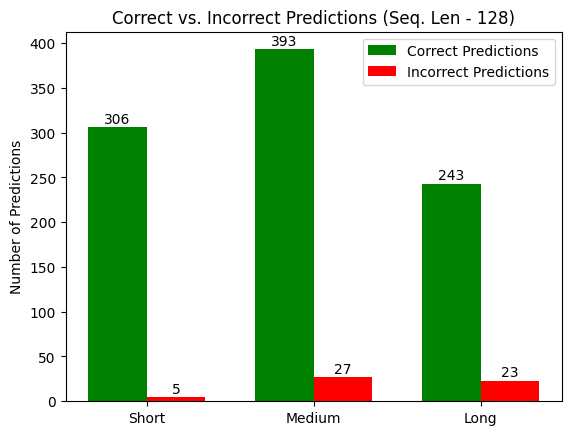

In [ ]:
# Bar chart
import matplotlib.pyplot as plt

# Define the data
labels = ['Short', 'Medium', 'Long']
correct_predictions = [correct_predictions_short, correct_predictions_medium, correct_predictions_long]
incorrect_predictions = [incorrect_predictions_short, incorrect_predictions_medium, incorrect_predictions_long]

# Create the figure and axes
fig, ax = plt.subplots()

# Define the width of each bar
bar_width = 0.35

# Create the bars
x_pos = np.arange(len(labels))
ax.bar(x_pos, correct_predictions, bar_width, label='Correct Predictions', color='g')
ax.bar(x_pos + bar_width, incorrect_predictions, bar_width, label='Incorrect Predictions', color='r')

# Add the labels and title
ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of Predictions')
ax.set_title('Correct vs. Incorrect Predictions (Seq. Len - {sequence_length})'.format(sequence_length=sequence_length))

# Add the counts overlay
for i, count in enumerate(correct_predictions):
    ax.annotate(str(count), xy=(i, count + 1), ha='center', va='bottom')
for i, count in enumerate(incorrect_predictions):
    ax.annotate(str(count), xy=(i + bar_width, count + 1), ha='center', va='bottom')

# Add the legend and show the plot
ax.legend()
plt.show()

 98%|█████████▊| 123/125 [00:05<00:00, 24.59it/s]c:\Users\Owner\anaconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 125/125 [00:06<00:00, 20.78it/s]


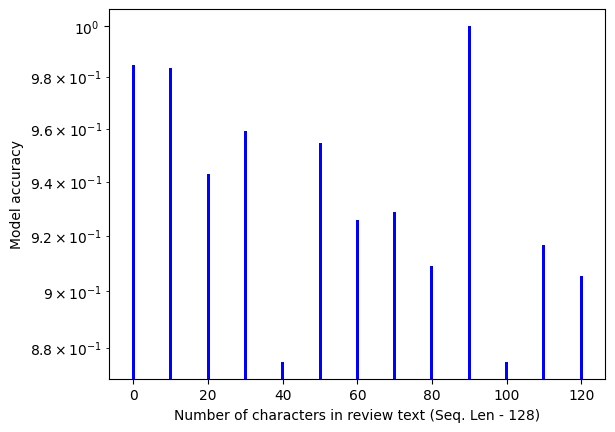

In [ ]:
# First, predict all the entries in df_test
predictions = trainer.predict(test_dataset)

# First, predict all the entries in df_test
df_review_lengths = df_test.copy()
df_review_lengths['review_length'] = df_review_lengths['review_text'].transform(lambda x: int(min(len(x), sequence_length) / 10) * 10)

# Convert the predictions to hard labels
hard_preds = np.argmax(predictions.predictions, axis=1)

# Get the true labels
true_labels = df_review_lengths['recommended']

accuracy_by_length = {}
for length in df_review_lengths['review_length'].unique():
  df_subset = df_review_lengths[df_review_lengths['review_length'] == length]
  true_labels = df_subset['recommended']
  predicted_labels = hard_preds[df_subset.index]
  accuracy = accuracy_score(true_labels, predicted_labels)
  accuracy_by_length[length] = accuracy

fig, ax = plt.subplots()
ax.bar(accuracy_by_length.keys(), accuracy_by_length.values(), color='b')
ax.set_xlabel('Number of characters in review text (Seq. Len - {sequence_length})'.format(sequence_length=sequence_length))
ax.set_ylabel('Model accuracy')
ax.set_yscale('log')
plt.show()